## リビジョン数 の分布をプロット
目的　：　SATDが含まれているファイルは積極的に開発や修正が行われているかどうか を調べる

In [1]:
import os, re
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
saikyo = pd.read_csv('./saikyo-data.csv')
saikyo.head(2)

,id,project,path,revision,url,link,start,end,isLicense,isAutoGenerated,isIncludedKeyword,satdKeyword,isIncludedOurKeyword,ourKeyword,isSelected,comment,below,class
0,1,31z4/storm-docker,31z4/storm-docker/1.1.3/Dockerfile\n31z4/storm...,664a7f4730f58be00fd7fe0526d2c13180107c6f,https://github.com/31z4/storm-docker/blob/664a...,https://github.com/31z4/storm-docker/blob/664a...,7\n7\n7,7\n7\n7,0,0,0,NaN,0,NaN,0.0,# Add a user with an explicit UID/GID and crea...,RUN set -eux; \\nRUN set -eux; \\nRUN set -eux; \,NaN
1,2,31z4/storm-docker,31z4/storm-docker/1.1.3/Dockerfile\n31z4/storm...,664a7f4730f58be00fd7fe0526d2c13180107c6f,https://github.com/31z4/storm-docker/blob/664a...,https://github.com/31z4/storm-docker/blob/664a...,14\n14\n14,14\n14\n14,0,0,0,NaN,0,NaN,0.0,# Install required packages,RUN set -eux; \\nRUN set -eux; \\nRUN set -eux; \,NaN


# プロジェクトごとのリビジョン数
debt と non-debt に分けて リビジョン数の分析

In [3]:
def revision(ignore_debt=False, ignore_nondebt=False):
    
    projectname = []
    count = []
    resultdir = os.listdir('./result')
    
    for file in resultdir:

        if file[-4:] != ".csv":
            continue

        elif file[-12:] == "_nondebt.csv" and ignore_nondebt:
            continue
        elif file[-12:] != "_nondebt.csv" and ignore_debt:
            continue

        df = pd.read_csv(f'./result/{file}', index_col=0)
        id = int(file.split('_')[0])
        project = str.lower(saikyo[saikyo["id"]==id]["project"].values[0])
        
        ## 重複を無視する
        if project in projectname:
            continue

        try:## リビジョンのユニーク数を取得
            i = int(df.nunique()["commitid"])
            projectname.append(project)
            count.append(i)
        ## ログが取れていないとここでエラーが出る
        except TypeError:
            pass
        
    
    return projectname, count

In [4]:
## SATD
debt0 = list(revision(ignore_debt=False, ignore_nondebt=True))

df0 = pd.DataFrame.from_dict({"project":debt0[0], "revision":debt0[1]})
debt_df0 = df0.sort_values(by='revision')
debt_df0.reset_index(drop=True, inplace=True)


## SATD以外
# nondebt0 = list(revision(ignore_debt=True, ignore_nondebt=False))

# df0 = pd.DataFrame.from_dict({"project":nondebt0[0], "revision":nondebt0[1]})
# nondebt_df0 = df0.sort_values(by='revision')
# nondebt_df0.reset_index(drop=True, inplace=True)


## 全てのリビジョン
ALL0 = list(revision(ignore_debt=False, ignore_nondebt=False))

df0 = pd.DataFrame.from_dict({"project":ALL0[0], "revision":ALL0[1]})
df0 = df0.sort_values(by='revision')
df0.reset_index(drop=True, inplace=True)

In [80]:
df0["revision"].astype(int, inplace=True)

0          4
1         21
2         21
3         25
4         26
       ...  
125    16205
126    27621
127    38675
128    38694
129    48108
Name: revision, Length: 130, dtype: int64

## プロジェクトの前リビジョン数
プロジェクトごとにみているため、nondebt SATD の中にも同じプロジェクトは存在している
SATD 総数 : 32 件
ALL 総数 : 130 件


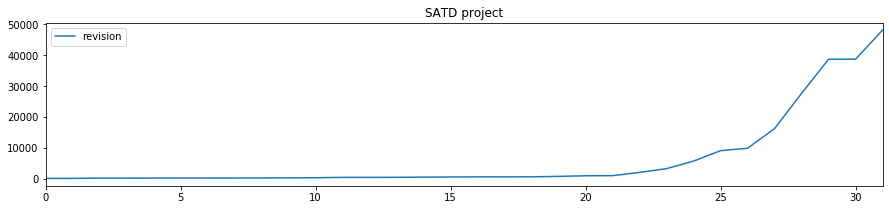

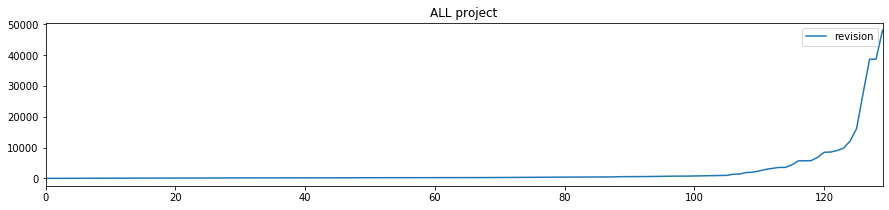

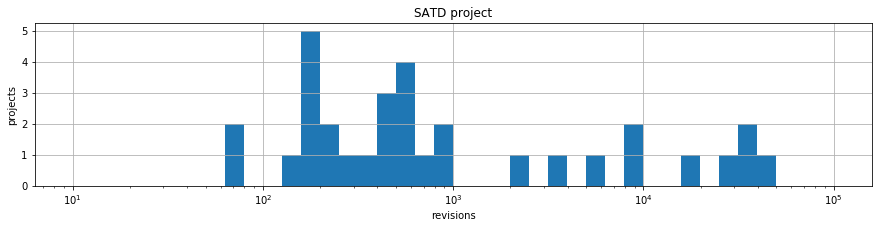

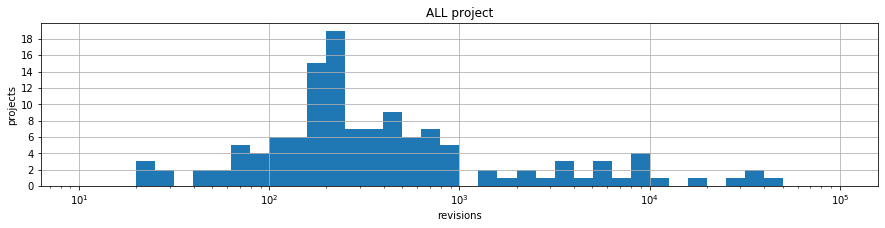

In [92]:
print("## プロジェクトの前リビジョン数")
print("プロジェクトごとにみているため、nondebt SATD の中にも同じプロジェクトは存在している")

print("SATD 総数 :", len(debt_df0), "件")
print("ALL 総数 :", len(df0), "件")

debt_df0.plot(figsize=(15, 3), title="SATD project");
# nondebt_df0.plot(figsize=(15, 3), title="non-debt");
df0.plot(figsize=(15, 3), title="ALL project");


debt_df0.hist(figsize=(15, 3), bins=np.logspace(1, 5, 41, base=10));
plt.title("SATD project")
plt.ylabel('projects')
plt.xlabel('revisions')
plt.xscale('log')
# plt.yticks(range(0, 11, 1))
plt.show()

df0.hist(figsize=(15, 3), bins=np.logspace(1, 5, 41, base=10));
plt.title("ALL project")
plt.ylabel('projects')
plt.xlabel('revisions')
plt.xscale('log')
plt.yticks(range(0, 20, 2))
plt.show()

# Dockerfileごとのリビジョン数
debt と non-debt に分けて リビジョン数の分析

### SATD追加前のコミットもとりあえず含めて考えてみる

In [7]:
# ## SATDが追加されてからのコミット回数を知りたい
#     ## よってSATD追加前の変更コミットを無視する (diff==0, and file==1 )
#     for col in df.columns.tolist()[3:]:
#         idx = df[(df["diff"]==1) & (df[col]==1)].index.tolist()[-1]
#         ## SATD追加時以前のコミットを０カウント
#         df.loc[idx+1:][col] = 0


def dockerfile_revision(ignore_debt=False, ignore_nondebt=False):

    project_dockerfiles = []
    count = []
    onehot_dir = os.listdir('./onehot-encoding')

    for file in tqdm(onehot_dir):

        if file[-4:] != ".csv":
            continue
        elif file[-12:] == "_nondebt.csv" and ignore_nondebt:
            continue
        elif file[-12:] != "_nondebt.csv" and ignore_debt:
            continue

        df = pd.read_csv(f'./onehot-encoding/{file}', index_col=0)
        id = int(file.split('_')[0])
        ## project name
        project = str.lower(saikyo[saikyo["id"]==id]["project"].values[0])

        columnsList = df.columns.tolist()[3:]
        ds = df.sum()

        for col in columnsList:
            ## ## project name
            name = f'{project}_{col}'
            ## 重複を削除
            if name in project_dockerfiles:
                continue

            ## sum でファイルごとのリビジョンの合計を取得している
            project_dockerfiles.append(name)
            i = ds[col]
            count.append(i)
    
    return project_dockerfiles, count

In [8]:
## SATD
debt1 = list(dockerfile_revision(ignore_debt=False, ignore_nondebt=True))

df1 = pd.DataFrame.from_dict({"dockerfile":debt1[0], "revision":debt1[1]})
debt_df1 = df1.sort_values(by='revision')
debt_df1.reset_index(drop=True, inplace=True)


## SATD以外
# nondebt = list(revision(ignore_debt=True, ignore_nondebt=False))

# df = pd.DataFrame.from_dict({"dockerfile":nondebt[0], "revision":nondebt[1]})
# nondebt_df = df.sort_values(by='revision')
# nondebt_df.reset_index(drop=True, inplace=True)


## 全てのリビジョン
ALL1 = list(dockerfile_revision(ignore_debt=False, ignore_nondebt=False))

df1 = pd.DataFrame.from_dict({"dockerfile":ALL1[0], "revision":ALL1[1]})
df1 = df1.sort_values(by='revision')
df1.reset_index(drop=True, inplace=True)

100%|██████████| 409/409 [02:37<00:00,  2.59it/s]


In [9]:
df1

,dockerfile,revision
0,wasdev/ci.docker_ga/20.0.0.5/kernel/Dockerfile...,1
1,microsoft/cntk_Tools/cmake/cpp_common.cmake,1
2,microsoft/cntk_bindings/csharp/Swig/Generated/...,1
3,zendtech/php-zendserver-docker_nightly/7.2/rep...,1
4,zendtech/php-zendserver-docker_nightly/7.2/rep...,1
...,...,...
2598,microsoft/cntk_Makefile,478
2599,docker/docker-ce_components/engine/Dockerfile,557
2600,docker/docker_Dockerfile,564
2601,moby/moby_Dockerfile,566


### グラフがわかりにくかったので作成し直す

## 修正点
* Dockerfileの数の記載
* 小規模のDockerfileについてもう少し詳細な結果を出力する
→ 対数グラフの利用

SATD 総数 : 309 件
ALL 総数 : 2603 件


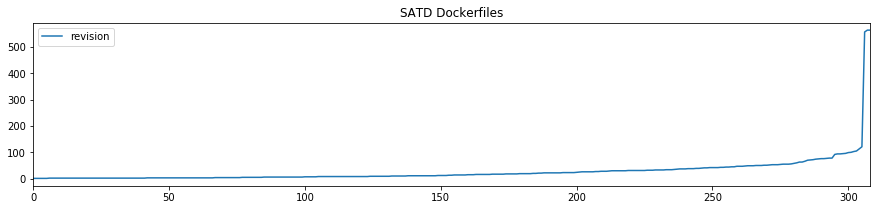

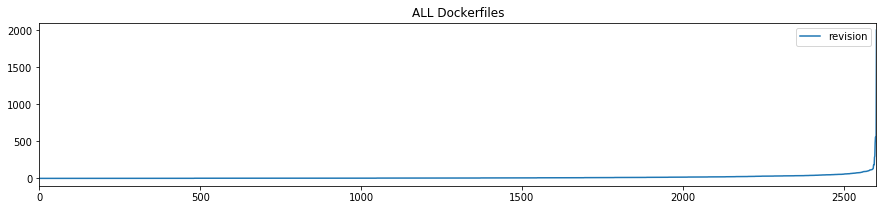

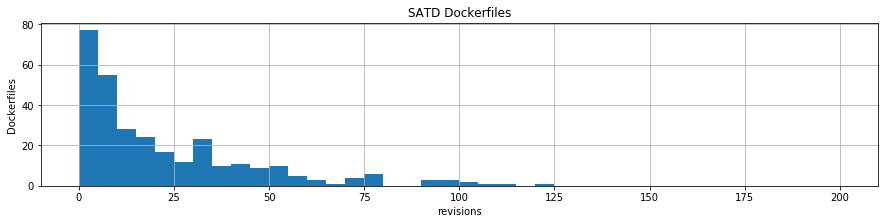

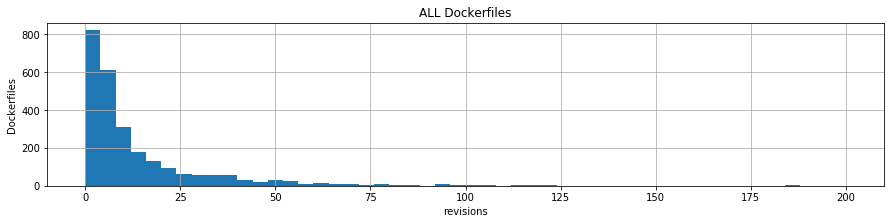

In [91]:

print("SATD 総数 :", len(debt_df1), "件")
print("ALL 総数 :", len(df1), "件")


debt_df1.plot(figsize=(15, 3), title="SATD Dockerfiles");
# nondebt_df.plot(figsize=(15, 3), title="non-debt");
df1.plot(figsize=(15, 3), title="ALL Dockerfiles");

debt_df1.hist(figsize=(15, 3), bins=40, range=(0, 200));
plt.title("SATD Dockerfiles")
plt.ylabel('Dockerfiles')
plt.xlabel('revisions')
plt.show()

df1.hist(figsize=(15, 3), bins=50, range=(0, 200));
plt.title("ALL Dockerfiles")
plt.ylabel('Dockerfiles')
plt.xlabel('revisions')
plt.show()
